In [15]:
from planet4 import io, region_data, markings
from p4_tools import get_final_markings_counts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import root, curve_fit, leastsq
import pdb
import shapely.geometry as shp
import fiona as fio
from shapely import affinity
from shapely.ops import cascaded_union, unary_union
import time

In [16]:
# read out metadata for season 2 and 3
meta = pd.read_csv('ithaca_metadata.csv')

# read out actual markings for fans and blotches, both seasons combined
fans = pd.read_csv('ithaca_fans.csv')
blotches = pd.read_csv('ithaca_blotches.csv')

# read out tile coordinate data
tiles = pd.read_csv('ithaca_tile_coords.csv')

In [17]:
# find unique obsids in the fans and blotches catalogs
fimg_names = fans.image_name.unique()
bimg_names = blotches.image_name.unique()
fimg_id = fans.image_id.unique()
bimg_id = blotches.image_id.unique()

# add column for tile info, fill with tile info
fans['tile_lat'] = 0
fans['tile_lon'] = 0
blotches['tile_lat'] = 0
blotches['tile_lon'] = 0
for i in range(len(fimg_id)):
    fans.tile_lat[fans.image_id==fimg_id[i]] = float(tiles.PlanetocentricLatitude[tiles.image_id==fimg_id[i]])
    fans.tile_lon[fans.image_id==fimg_id[i]] = float(tiles.PositiveEast360Longitude[tiles.image_id==fimg_id[i]])
for i in range(len(bimg_id)):
    blotches.tile_lat[blotches.image_id==bimg_id[i]] = float(tiles.PlanetocentricLatitude[tiles.image_id==bimg_id[i]])
    blotches.tile_lon[blotches.image_id==bimg_id[i]] = float(tiles.PositiveEast360Longitude[tiles.image_id==bimg_id[i]])
    
# add column for season flag and validity of marking
fans['season'] = 0
fans['valid_marking'] = True
blotches['season'] = 0
blotches['valid_marking'] = True
blotches['area'] = np.pi * blotches.radius_1 * blotches.radius_2 / 4

# define column for season flag
fans.season[fans.obsid.str[5] == '1'] = 2
fans.season[fans.obsid.str[5] == '2'] = 3
blotches.season[blotches.obsid.str[5] == '1'] = 2
blotches.season[blotches.obsid.str[5] == '2'] = 3

/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.

In [18]:
# find what size fans should be removed for fair comparison
min_fan_pixels = fans.distance.min()
min_bl_area = blotches.area.min()

max_scale = np.max( meta.map_scale.max() )
print('maximum map_scale:',  max_scale, '; min_fan_marking:', min_fan_pixels, '; min_bl_area:', min_bl_area)

# if the minimal fan marking tool is = 10 pixels at max_bin = 4, it will correspond to  
# min_fan_pixels * max_binning / image_binning
meta['min_fan'] = min_fan_pixels * meta.map_scale.max() // meta.map_scale + 1

# if the minimal blotch marking tool is = 80 sq. pixels at max_bin = 4, it will correspond to  
# min_bl_area * max_binning^2 / image_binning^2
meta['min_bl'] = min_bl_area * meta.map_scale.max()**2 // meta.map_scale**2 + 1


maximum map_scale: 1.0 ; min_fan_marking: 10.0 ; min_bl_area: 78.5398163397


In [19]:
# mark "valid_marking" key to be False for blotch markings smaller than min_bl for that image
print(len(blotches))
for i in range(len(blotches)):
    nr_image =  np.where(meta.obsid == blotches.obsid[i])[0][0]        
    min_b = meta.min_bl[ nr_image  ]         
    if (blotches.area[i] < min_b ):
        blotches.valid_marking[i] = False
            
# mark "valid_marking" key to be False for fan markings smaller than min_fan for that image
for i in range(len(fans)):
    nr_image =  np.where(meta.obsid == fans.obsid[i])[0][0]        
    min_f = meta.min_fan[ nr_image  ]         
    if (fans.distance[i] < min_f ):
        fans.valid_marking[i] = False

/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


18045


/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
# create new data frame for all objects and metadata, select only objects that are valid markings
objects = pd.DataFrame({'name':pd.concat((fans.image_name[fans.valid_marking==True],blotches.image_name[blotches.valid_marking==True])),\
                        'type':np.zeros(len(fans.valid_marking[fans.valid_marking==True])+len(blotches.valid_marking[blotches.valid_marking==True])),\
                        'long':pd.concat((fans.distance[fans.valid_marking==True],blotches.radius_1[blotches.valid_marking==True])),\
                        'short':pd.concat((fans.spread[fans.valid_marking==True],blotches.radius_2[blotches.valid_marking==True])),\
                        'x':pd.concat((fans.image_x[fans.valid_marking==True],blotches.image_x[blotches.valid_marking==True])),\
                        'y':pd.concat((fans.image_y[fans.valid_marking==True],blotches.image_y[blotches.valid_marking==True])),\
                        'angle':pd.concat((fans.angle[fans.valid_marking==True],blotches.angle[blotches.valid_marking==True])),\
                        'binning':np.zeros(len(fans.valid_marking[fans.valid_marking==True])+len(blotches.valid_marking[blotches.valid_marking==True])),\
                        'l_s':np.zeros(len(fans.valid_marking[fans.valid_marking==True])+len(blotches.valid_marking[blotches.valid_marking==True])),\
                        'x_angle':pd.concat((fans.x_angle[fans.valid_marking==True],blotches.x_angle[blotches.valid_marking==True])),\
                        'y_angle':pd.concat((fans.y_angle[fans.valid_marking==True],blotches.y_angle[blotches.valid_marking==True])),\
                        'tile_lat':pd.concat((fans.tile_lat[fans.valid_marking==True],blotches.tile_lat[blotches.valid_marking==True])),\
                        'tile_lon':pd.concat((fans.tile_lon[fans.valid_marking==True],blotches.tile_lon[blotches.valid_marking==True]))}).reset_index(drop=True)

In [21]:
# get list of unique images
img_unique = objects.name.unique()

# add columns for coverage and season in the meta dataframe
meta['coverage'] = 0
meta['coverage_redundant'] = 0

# add column for binning and l_s, fill with info from meta
for k in range(img_unique.size):
    loc = np.where(objects.name==img_unique[k])[0]
    m_loc = np.where(meta.obsid==img_unique[k])[0]
    objects.loc[loc,'binning'] = np.asarray(meta.loc[m_loc,'binning'])
    objects.loc[loc,'l_s'] = np.asarray(meta.loc[m_loc,'l_s'])

# record type of each object - they are still in order from concatenation so this can be done with indexing
split = len(fans.valid_marking[fans.valid_marking==True])
objects.loc[:split,'type'] = 'f'
objects.loc[split:,'type'] = 'b'

#re-sort objects according to image, so that blotches and fans for the same image won't be split up
objects = objects.sort_values(by='name').reset_index(drop=True)
meta = meta.sort_values(by='obsid').reset_index(drop=True)

In [22]:
# create a list to store points corresponding to the corners (bounds) of each HiRise image
# and a list to store the polygons made from the sets of points
points = [None] * 4
img_shapes = [None] * len(img_unique)
plt.figure(1)
for i in range(len(img_unique)):
    boundshi = max(objects.tile_lat[objects.name==img_unique[i]])
    boundsri = max(objects.tile_lon[objects.name==img_unique[i]])
    boundslo = min(objects.tile_lat[objects.name==img_unique[i]])
    boundsle = min(objects.tile_lon[objects.name==img_unique[i]])
    points[0] = (boundshi,boundsri)
    points[1] = (boundslo,boundsri)
    points[2] = (boundslo,boundsle)
    points[3] = (boundshi,boundsle)
    img_shapes[i] = shp.Polygon(points[:])
    # plot the outlines of the HiRise images as an example
    x,y = img_shapes[i].exterior.xy
    plt.plot(x,y)

In [23]:
# create arrays to store info on non-overlapping images
misses = np.zeros((len(img_unique),len(img_unique)))
ind2drop = np.zeros((len(img_unique)),dtype=int)

# loop through images
for i in range(len(img_unique)):
    # loop through other images to check image [i]
    for j in range(len(img_unique)-i-1):
        # check if image[i] intersects the current image, if not, add a 1 in 'misses' array 
        # with index corresponding to the two non-overlapping images
        if img_shapes[i].intersects(img_shapes[i+j+1])==False:
            misses[i,i+j+1] = 1 

# loop through possible cases of non-overlap
for n in range(len(img_unique)):
    # if all images intersect somewhwere, misses will be only zeros and the loop should be broken
    if np.sum(misses)==0:
        break
    # get indices of flags in 'misses'
    miss_inds = np.where(misses!=0)
    # get which images were involved, sort by involvement
    miss_unique = np.unique(miss_inds,return_counts=True)
    # find which image came up the most in 'misses' - this is the one to remove next iteration
    miss_max = max(miss_unique[1])
    miss_max_ind = np.where(miss_unique[1]==miss_max)[0][0]
    # get the index of that image in the collection of polygons 'img_shapes', add one so that 
    # the index '0' wouldn't get missed
    ind2drop[n] = int(miss_unique[0][miss_max_ind]) + 1
    # clear 'misses' of any flags corresponding to that image becuase it has been found all ready
    misses[:,int(ind2drop[n])-1] = 0
    misses[int(ind2drop[n])-1,:] = 0

In [24]:
# trim off excess zeroes in 'ind2drop'
ind2drop = np.delete(ind2drop,np.where(ind2drop==0.0))

# 'safe' is 1 where the index refers to an object to-be-dropped, and 0 otherwise (zeroes are safe objects)
safe = np.zeros((len(img_unique)))
safe[ind2drop-1] = 1

# 'safes' are the indices of all safe objects, the first of which is the starting point for the next loop,
# which is necessary to know in cases where the first few images are to-be-dropped
safes = np.where(safe==0)
start = int(safes[0][0])

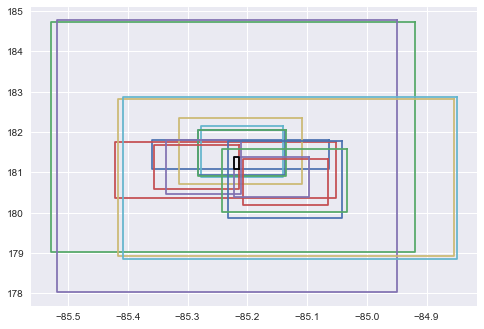

In [25]:
# loop through images to define area with highest degree of overlap
for i in range(len(img_unique)):
    # first iteration - intersection of first and second object is the temporary object
    if i == 0:
        inter_temp = img_shapes[i].intersection(img_shapes[i+1])
        # if '0' or '1' is an index-to-drop, temporary object is just the first safe object
        if any([z-1==i for z in ind2drop]) or any([z-1==i+1 for z in ind2drop]):
            inter_temp = img_shapes[start]
        continue
    # if this is the last iteration, temporary object is the final object
    elif i == (len(img_unique)-1):
        inter = inter_temp
        break
    # if the loop is on an index-to-drop, continue to next iteration, omitting this object
    # from the calculation of 'inter'
    elif any([z-1==i+1 for z in ind2drop])==True:
        continue
    # normal action - update temporary object as intersection with the next object in 'img_shapes'
    else:
        inter_temp = inter_temp.intersection(img_shapes[i+1])

# plot the outline of the most overlapped area found in black, should look reasonable on previous plot
xi,yi = inter.exterior.xy
plt.plot(xi,yi,'k')
plt.show()

In [26]:
# 'buffer' is a factor that determines how far inside or outside the extents of 'inter' an object's tile's 
# must be to be considered for calculation. a positive number allows objects outside 'inter' to be considered
buffer = 0.0005
# define lat/lon corresponding to corners of 'inter'
lo_lat = xi[2] * (1. + buffer)
hi_lat = xi[0] * (1. - buffer)
lo_lon = yi[0] * (1. - buffer)
hi_lon = yi[2] * (1. + buffer)

# 'overlap_objs' are all the objects whose tile center is within the allowable distance around 'inter'
overlap_objs = objects.loc[(objects['tile_lat'] > lo_lat) & (objects['tile_lon'] < hi_lon) & (objects['tile_lat'] < hi_lat) & (objects['tile_lon'] > lo_lon)]
ol_img_unique = overlap_objs.name.unique()

In [27]:
# create arrays to be filled
n_ol_img = len(ol_img_unique)
n_marks = np.zeros((n_ol_img,3))
n_objs = overlap_objs.name.value_counts()[0]
img_fans = np.zeros((n_ol_img,n_objs))
img_blotches = np.zeros((n_ol_img,n_objs))
f_histmax = np.zeros((n_ol_img))
b_histmax = np.zeros((n_ol_img))

In [28]:
# loop through each image
for i in range(n_ol_img):
    # get set of fans & blotches for each image, and get list of tiles in which these are contained
    fans_ = overlap_objs.name[(overlap_objs.type=='f') & (overlap_objs.name==ol_img_unique[i])]
    blotches_ = overlap_objs.name[(overlap_objs.type=='b') & (overlap_objs.name==ol_img_unique[i])]
    fans_tiles = overlap_objs.tile_lat[(overlap_objs.name==ol_img_unique[i]) & (overlap_objs.type=='f')]
    blotches_tiles = overlap_objs.tile_lat[(overlap_objs.name==ol_img_unique[i]) & (overlap_objs.type=='b')]
    
    # for each image, record l_s and the number of fans & blotches divided by the number of tiles considered
    if len(fans_) > 0 and len(blotches_) > 0:
        n_marks[i,0] = meta.l_s[meta.obsid==ol_img_unique[i]]
        n_marks[i,1] = len(fans_)/len(fans_tiles.value_counts())
        n_marks[i,2] = len(blotches_)/len(blotches_tiles.value_counts())
    elif len(fans_) == 0:
        n_marks[i,0] = meta.l_s[meta.obsid==ol_img_unique[i]]
        n_marks[i,1] = np.nan
        n_marks[i,2] = len(blotches_)/len(blotches_tiles.value_counts())
    elif len(blotches_) == 0:
        n_marks[i,0] = meta.l_s[meta.obsid==ol_img_unique[i]]
        n_marks[i,1] = len(fans_)/len(fans_tiles.value_counts())
        n_marks[i,2] = np.nan
    
    # get lengths and binnings of fans & blotches for each image, multiply these, fill length array (for fans)
    # and area array (for blotches) with result
    fan_lengths = overlap_objs.long[(overlap_objs.name==ol_img_unique[i]) & (overlap_objs.type=='f')]
    fan_binning = overlap_objs.binning[(overlap_objs.name==ol_img_unique[i]) & (overlap_objs.type=='f')]
    #img_fans[i,:len(fans_)] = fan_lengths * fan_binning
    img_fans[i,:len(fans_)] = fan_lengths
    blotch_len1 = overlap_objs.long[(overlap_objs.name==ol_img_unique[i]) & (overlap_objs.type=='b')]
    blotch_len2 = overlap_objs.short[(overlap_objs.name==ol_img_unique[i]) & (overlap_objs.type=='b')]
    blotch_binning = overlap_objs.binning[(overlap_objs.name==ol_img_unique[i]) & (overlap_objs.type=='b')]
    #img_blotches[i,:len(blotches_)] = blotch_len1 * blotch_len2 * blotch_binning * np.pi
    img_blotches[i,:len(blotches_)] = blotch_len1 * blotch_len2 * np.pi
    
    # create a histogram of fans' & blotches' size distribution for each image,
    # find max of each histogram, record in 'histmax'
    f_hist,f_binedges = np.histogram(img_fans[i,np.where(img_fans[i,:]>0.0)],bins=50)
    f_histmax[i] = f_binedges[np.where(f_hist==f_hist.max())[0][0]]
    b_hist,b_binedges = np.histogram(img_blotches[i,np.where(img_blotches[i,:]>0.0)],bins=50)
    b_histmax[i] = b_binedges[np.where(b_hist==b_hist.max())[0][0]]
    # replace zeroes with NaN's
    if f_histmax[i]==0:
        f_histmax[i] = np.nan
    if b_histmax[i]==0:
        b_histmax[i] = np.nan

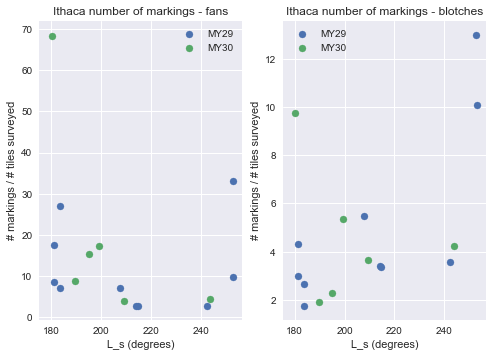

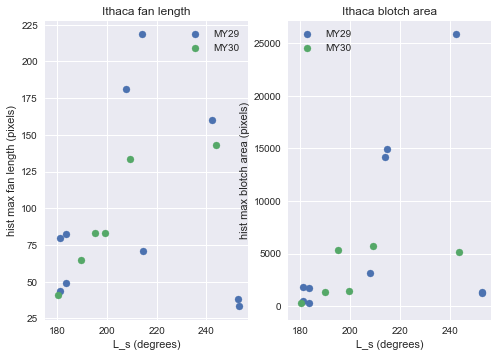

In [29]:
# plot data
season_split = len(meta[meta.season=='season2'])
plt.figure(2)
plt.subplot(121)
plt.scatter(n_marks[:season_split,0],n_marks[:season_split,1],label='MY29')
plt.scatter(n_marks[season_split:,0],n_marks[season_split:,1],label='MY30')
plt.legend()
plt.title('Ithaca number of markings - fans')
plt.xlabel('L_s (degrees)')
plt.ylabel('# markings / # tiles surveyed')
plt.subplot(122)
plt.scatter(n_marks[:season_split,0],n_marks[:season_split,2],label='MY29')
plt.scatter(n_marks[season_split:,0],n_marks[season_split:,2],label='MY30')
plt.legend()
plt.title('Ithaca number of markings - blotches')
plt.xlabel('L_s (degrees)')
plt.ylabel('# markings / # tiles surveyed')
plt.figure(3)
plt.subplot(121)
plt.scatter(n_marks[:season_split,0],f_histmax[:season_split],label='MY29')
plt.scatter(n_marks[season_split:,0],f_histmax[season_split:],label='MY30')
plt.legend()
plt.title('Ithaca fan length')
plt.xlabel('L_s (degrees)')
plt.ylabel('hist max fan length (pixels)')
plt.subplot(122)
plt.scatter(n_marks[:season_split,0],b_histmax[:season_split],label='MY29')
plt.scatter(n_marks[season_split:,0],b_histmax[season_split:],label='MY30')
plt.legend()
plt.title('Ithaca blotch area')
plt.xlabel('L_s (degrees)')
plt.ylabel('hist max blotch area (pixels)')
plt.show()